In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
import gc
import pickle

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.xgb import fit_xgb
from utils.metric import compute_comptetition_metric
from utils.postprocess import post_process
from utils.set_seed import seed_base
from feature_engineering.stage2 import generate_2nd_stage_features

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG["2nd_stage"]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG['2nd_stage']['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-10-22 07:35:17.203207: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-22 07:35:17.554806: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-22 07:35:18.678064: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_096


In [2]:
# 特徴生成
files = glob(f"{CFG['dataset']['step_csv_dir']}/*.parquet")
train, features = generate_2nd_stage_features(files)

# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train["fold"] = train["series_id"].map(cv_split.set_index("series_id")["fold"])
display(train.head(5))
train.shape

generate features: 100%|██████████| 277/277 [03:14<00:00,  1.43it/s]


,anglez,anglez_diff_abs,anglez_diff_abs_clip5,anglez_mean,enmo,enmo_diff_abs,enmo_mean,minutes,same_count,total_seconds,...,anglez_diff_abs_rolling_max_100_shift_1000,anglez_diff_abs_clip5_rolling_max_100_shift_1000,enmo_rolling_median_100_shift_1000,anglez_diff_abs_rolling_median_100_shift_1000,anglez_diff_abs_clip5_rolling_median_100_shift_1000,enmo_rolling_square_mean_100_shift_1000,anglez_diff_abs_rolling_square_mean_100_shift_1000,anglez_diff_abs_clip5_rolling_square_mean_100_shift_1000,reduce_step,fold
622,-1.160092,5.391342,3.805200,-1.160092,0.049821,0.022942,0.049822,1797.5,6.5,32397.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14939,3
623,-6.169150,4.236796,2.998800,-6.169149,0.026333,0.008512,0.026335,117.5,0.0,32517.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14963,3
624,-14.701716,3.183992,2.853704,-14.701717,0.033279,0.007212,0.033278,237.5,0.0,32637.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14987,3
625,-12.253108,3.600733,3.046375,-12.253112,0.057471,0.028133,0.057472,357.5,0.0,32757.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15011,3
626,-6.187904,3.673754,2.645983,-6.187906,0.049892,0.030817,0.049891,477.5,0.0,32877.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15035,3


(877617, 977)

In [3]:
# 学習
dfs = []
for event in ["wakeup", "onset"]:
    trn_oof, models = fit_xgb(
        X=train, 
        y=train[f"{event}_target"], 
        folds=train["fold"].astype(int), 
        features=features.all_features(),
        params=CFG["2nd_stage"]["xgboost"], 
        es_rounds=100,
    )
    train["score"] = trn_oof
    train["event"] = event
    dfs.append(train[["series_id", "step", "score", "event"]])

    # 保存
    for i, model in enumerate(models):
        model.save_model(os.path.join(CFG["output_dir"], f'xgb_{event}_fold_{i}.model'))
del train
gc.collect()
train = pd.concat(dfs, axis=0)
train["step"] = train["step"].astype(int)
train = train.sort_values(["series_id", "step"]).reset_index(drop=True)


with open(os.path.join(CFG["output_dir"], "features.pkl"), "wb") as f:
    pickle.dump(features, f)
train.to_csv(os.path.join(CFG["output_dir"], "oof.csv"), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:1.81784
[100]	eval-rmse:1.11649
[200]	eval-rmse:0.95453
[300]	eval-rmse:0.91999
[400]	eval-rmse:0.90918
[500]	eval-rmse:0.90546
[600]	eval-rmse:0.90380
[700]	eval-rmse:0.90246
[800]	eval-rmse:0.90119
[900]	eval-rmse:0.90041
[1000]	eval-rmse:0.89974
[1100]	eval-rmse:0.89936
[1200]	eval-rmse:0.89901
[1300]	eval-rmse:0.89864
[1400]	eval-rmse:0.89846
[1500]	eval-rmse:0.89835
[1600]	eval-rmse:0.89821
[1700]	eval-rmse:0.89814
[1800]	eval-rmse:0.89800
[1900]	eval-rmse:0.89778
[2000]	eval-rmse:0.89771
[2100]	eval-rmse:0.89771
[2200]	eval-rmse:0.89768
[2275]	eval-rmse:0.89766


 20%|██        | 1/5 [01:46<07:04, 106.15s/it]

== fold 1 ==
[0]	eval-rmse:1.70126
[100]	eval-rmse:1.06781
[200]	eval-rmse:0.92147
[300]	eval-rmse:0.88535
[400]	eval-rmse:0.87273
[500]	eval-rmse:0.86729
[600]	eval-rmse:0.86418
[700]	eval-rmse:0.86219
[800]	eval-rmse:0.86030
[900]	eval-rmse:0.85887
[1000]	eval-rmse:0.85769
[1100]	eval-rmse:0.85674
[1200]	eval-rmse:0.85608
[1300]	eval-rmse:0.85539
[1400]	eval-rmse:0.85501
[1500]	eval-rmse:0.85428
[1600]	eval-rmse:0.85392
[1700]	eval-rmse:0.85343
[1800]	eval-rmse:0.85292
[1900]	eval-rmse:0.85266
[2000]	eval-rmse:0.85248
[2100]	eval-rmse:0.85215
[2200]	eval-rmse:0.85222
[2212]	eval-rmse:0.85219


 40%|████      | 2/5 [03:28<05:11, 103.86s/it]

== fold 2 ==
[0]	eval-rmse:1.73939
[100]	eval-rmse:1.10493
[200]	eval-rmse:0.95678
[300]	eval-rmse:0.91964
[400]	eval-rmse:0.90823
[500]	eval-rmse:0.90334
[600]	eval-rmse:0.90147
[700]	eval-rmse:0.90013
[800]	eval-rmse:0.89905
[900]	eval-rmse:0.89830
[1000]	eval-rmse:0.89729
[1100]	eval-rmse:0.89659
[1200]	eval-rmse:0.89615
[1300]	eval-rmse:0.89568
[1400]	eval-rmse:0.89539
[1500]	eval-rmse:0.89508
[1600]	eval-rmse:0.89499
[1700]	eval-rmse:0.89499
[1720]	eval-rmse:0.89498


 60%|██████    | 3/5 [04:50<03:07, 93.75s/it] 

== fold 3 ==
[0]	eval-rmse:1.71232
[100]	eval-rmse:1.04971
[200]	eval-rmse:0.88760
[300]	eval-rmse:0.84955
[400]	eval-rmse:0.83856
[500]	eval-rmse:0.83497
[600]	eval-rmse:0.83424
[700]	eval-rmse:0.83344
[800]	eval-rmse:0.83266
[900]	eval-rmse:0.83239
[1000]	eval-rmse:0.83218
[1100]	eval-rmse:0.83201
[1200]	eval-rmse:0.83184
[1300]	eval-rmse:0.83172
[1400]	eval-rmse:0.83161
[1500]	eval-rmse:0.83139
[1578]	eval-rmse:0.83141


 80%|████████  | 4/5 [06:07<01:27, 87.12s/it]

== fold 4 ==
[0]	eval-rmse:1.78913
[100]	eval-rmse:1.12016
[200]	eval-rmse:0.96496
[300]	eval-rmse:0.92887
[400]	eval-rmse:0.91761
[500]	eval-rmse:0.91488
[600]	eval-rmse:0.91308
[700]	eval-rmse:0.91173
[800]	eval-rmse:0.91095
[900]	eval-rmse:0.91052
[1000]	eval-rmse:0.91003
[1100]	eval-rmse:0.90966
[1200]	eval-rmse:0.90946
[1300]	eval-rmse:0.90935
[1372]	eval-rmse:0.90934


  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:1.81450
[100]	eval-rmse:1.12928
[200]	eval-rmse:0.96077
[300]	eval-rmse:0.91784
[400]	eval-rmse:0.90402
[500]	eval-rmse:0.89993
[600]	eval-rmse:0.89848
[700]	eval-rmse:0.89732
[800]	eval-rmse:0.89678
[900]	eval-rmse:0.89657
[1000]	eval-rmse:0.89601
[1100]	eval-rmse:0.89563
[1200]	eval-rmse:0.89529
[1300]	eval-rmse:0.89505
[1400]	eval-rmse:0.89470
[1500]	eval-rmse:0.89461
[1600]	eval-rmse:0.89451
[1700]	eval-rmse:0.89430
[1800]	eval-rmse:0.89407
[1900]	eval-rmse:0.89397
[2000]	eval-rmse:0.89370
[2100]	eval-rmse:0.89366
[2187]	eval-rmse:0.89364


 20%|██        | 1/5 [01:42<06:48, 102.06s/it]

== fold 1 ==
[0]	eval-rmse:1.69721
[100]	eval-rmse:1.07488
[200]	eval-rmse:0.92559
[300]	eval-rmse:0.88312
[400]	eval-rmse:0.86735
[500]	eval-rmse:0.86062
[600]	eval-rmse:0.85770
[700]	eval-rmse:0.85595
[800]	eval-rmse:0.85473
[900]	eval-rmse:0.85376
[1000]	eval-rmse:0.85297
[1100]	eval-rmse:0.85197
[1200]	eval-rmse:0.85124
[1300]	eval-rmse:0.85058
[1400]	eval-rmse:0.85035
[1500]	eval-rmse:0.84991
[1600]	eval-rmse:0.84972
[1700]	eval-rmse:0.84962
[1733]	eval-rmse:0.84958


 40%|████      | 2/5 [03:06<04:34, 91.42s/it] 

== fold 2 ==
[0]	eval-rmse:1.74094
[100]	eval-rmse:1.12362
[200]	eval-rmse:0.97585
[300]	eval-rmse:0.93447
[400]	eval-rmse:0.92115
[500]	eval-rmse:0.91385
[600]	eval-rmse:0.91062
[700]	eval-rmse:0.90864
[800]	eval-rmse:0.90742
[900]	eval-rmse:0.90621
[1000]	eval-rmse:0.90528
[1100]	eval-rmse:0.90483
[1200]	eval-rmse:0.90421
[1300]	eval-rmse:0.90363
[1400]	eval-rmse:0.90307
[1500]	eval-rmse:0.90272
[1600]	eval-rmse:0.90251
[1700]	eval-rmse:0.90217
[1800]	eval-rmse:0.90169
[1900]	eval-rmse:0.90137
[2000]	eval-rmse:0.90125
[2100]	eval-rmse:0.90119
[2200]	eval-rmse:0.90073
[2300]	eval-rmse:0.90072
[2400]	eval-rmse:0.90044
[2500]	eval-rmse:0.90010
[2600]	eval-rmse:0.89993
[2700]	eval-rmse:0.89973
[2800]	eval-rmse:0.89953
[2900]	eval-rmse:0.89934
[3000]	eval-rmse:0.89913
[3068]	eval-rmse:0.89920


 60%|██████    | 3/5 [05:22<03:44, 112.09s/it]

== fold 3 ==
[0]	eval-rmse:1.70641
[100]	eval-rmse:1.08752
[200]	eval-rmse:0.94450
[300]	eval-rmse:0.91121
[400]	eval-rmse:0.90127
[500]	eval-rmse:0.89787
[600]	eval-rmse:0.89721
[700]	eval-rmse:0.89649
[800]	eval-rmse:0.89645
[844]	eval-rmse:0.89642


 80%|████████  | 4/5 [06:08<01:26, 86.05s/it] 

== fold 4 ==
[0]	eval-rmse:1.77911
[100]	eval-rmse:1.13990
[200]	eval-rmse:0.99239
[300]	eval-rmse:0.95550
[400]	eval-rmse:0.94258
[500]	eval-rmse:0.93725
[600]	eval-rmse:0.93506
[700]	eval-rmse:0.93296
[800]	eval-rmse:0.93177
[900]	eval-rmse:0.93086
[1000]	eval-rmse:0.93031
[1100]	eval-rmse:0.92995
[1200]	eval-rmse:0.92960
[1300]	eval-rmse:0.92912
[1400]	eval-rmse:0.92877
[1500]	eval-rmse:0.92834
[1600]	eval-rmse:0.92828
[1700]	eval-rmse:0.92822
[1800]	eval-rmse:0.92807
[1900]	eval-rmse:0.92776
[1974]	eval-rmse:0.92771


100%|██████████| 5/5 [07:41<00:00, 92.36s/it]


## Dynamic-Range NMS

<AxesSubplot: >

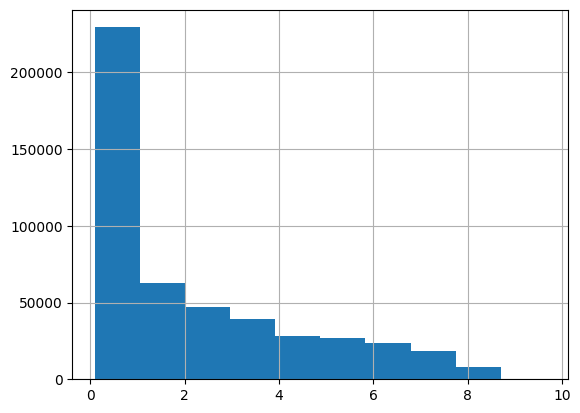

In [4]:
train = train[train["score"] > 0.1]
train["score"].hist()

In [5]:
from utils.postprocess import dynamic_range_nms
from multiprocessing import Pool
from tqdm import tqdm

train["step"] = train["step"].astype(int)

groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(dynamic_range_nms, groups), total=len(groups)))
sub = pd.concat(results)
sub["score"] = sub["reduced_score"]

100%|██████████| 277/277 [00:06<00:00, 44.19it/s]


In [6]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)

print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission_after_nms.csv"), index=False)

score: 0.7449


event   tolerance
onset   12           0.149125
        36           0.547793
        60           0.703088
        90           0.787806
        120          0.827223
        150          0.849892
        180          0.864039
        240          0.879307
        300          0.886963
        360          0.892803
wakeup  12           0.146292
        36           0.552066
        60           0.720219
        90           0.795903
        120          0.833481
        150          0.865255
        180          0.878150
        240          0.896186
        300          0.906425
        360          0.915757
dtype: float64